We are going to start with editing photos so they are similar for code to analyse:
- crop them
- make them grey scale
- reduce noise
- edit brightness

In [1]:
import cv2 #opencv -
import matplotlib.pyplot as plt
import numpy as np

In [2]:
"""General settings """
MIN_ELIPSE_ECCENTRICITY = 0.99
MIN_ELIPSE_AXIS = 20
MIN_SUNSPOT= 0.00001 #in relation to the Sun Area
MAX_SUNSPOT= 0.5
MIN_OVERALL_SUNSPOT_AREA = 0.01

"""4096 quality settings """
FONTSCALE4096 = 6
THICKNESS4096 = 10
EDGEKERNEL4096 = np.ones((3, 3), np.uint8) 
CONTOURSSIZE4096 =5 

"""1026 quality settings """
FONTSCALE1026 = 2
THICKNESS1026 = 3
CONTOURSSIZE1026 =2 

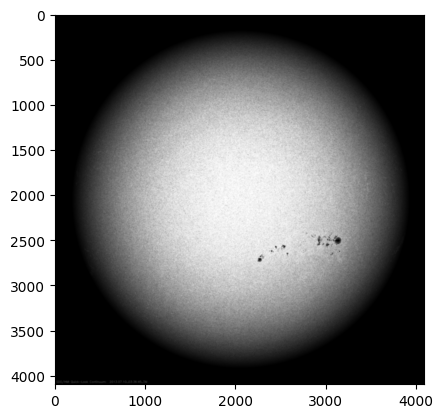

In [3]:
file_name="sdo_data/2013-07-10_3_36_10.jpg"

image_original = cv2.imread(file_name)
image = cv2.cvtColor(image_original, cv2.COLOR_RGB2GRAY)
equalized_image = cv2.equalizeHist(image)
blurred = cv2.GaussianBlur(equalized_image, (21,21), 0) 

plt.imshow(blurred, cmap='gray')
height, width = image_original.shape[:2]

#APPLY OPTIONS
if height == 4096:
    font_scale =FONTSCALE4096
    thickness = THICKNESS4096
    contour_size = CONTOURSSIZE4096
elif height ==1026:
    font_scale = FONTSCALE1026
    thickness = THICKNESS1026
    contour_size = CONTOURSSIZE1026
else:
    print("Uknown size")

First we are looking for ellipse containing the Sun

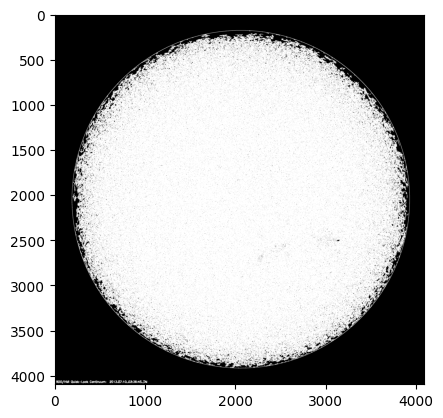

In [4]:
edges = cv2.Canny(image, 10, 50)
kernel = np.ones((3, 3), np.uint8) 
edges_dilated = cv2.dilate(edges, kernel, iterations=1)
plt.imshow(edges_dilated,cmap='gray')

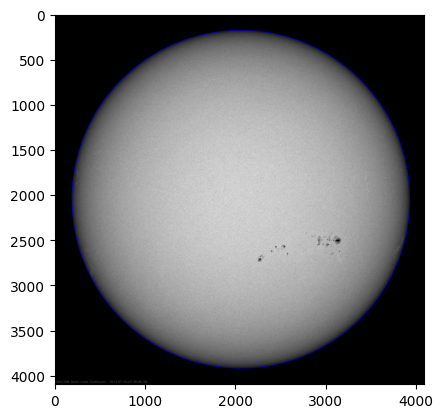

In [5]:
contours, _ = cv2.findContours(edges_dilated, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
if len(contours) > 0:
    elipses =[]
    areas = []
    for cnt in contours:
        if len(cnt)>=5:
            sun_ellipse = cv2.fitEllipse(cnt)
            if sun_ellipse:
                (cx, cy), (major_axis, minor_axis), angle = sun_ellipse
                sun_area=np.pi*major_axis/2*minor_axis/2
                if not (np.isnan(sun_area) or major_axis<=MIN_ELIPSE_AXIS or minor_axis<=MIN_ELIPSE_AXIS or major_axis/minor_axis < MIN_ELIPSE_ECCENTRICITY):
                    elipses.append(sun_ellipse)
                    areas.append(sun_area)
    max_index = np.argmax(areas)
    sun_ellipse=elipses[max_index]
    (cx, cy), (major_axis, minor_axis), angle = sun_ellipse
    image_elipse = image_original.copy()
    cv2.ellipse(image_elipse, sun_ellipse, (255, 0, 0), contour_size)
    plt.imshow(cv2.cvtColor(image_elipse, cv2.COLOR_BGR2RGB))
else:
    print("No contours found!")


now we are going to take inside of the sun and use dynamic threshhold on it in orderd to eliminated diffrences in lighting near the edge

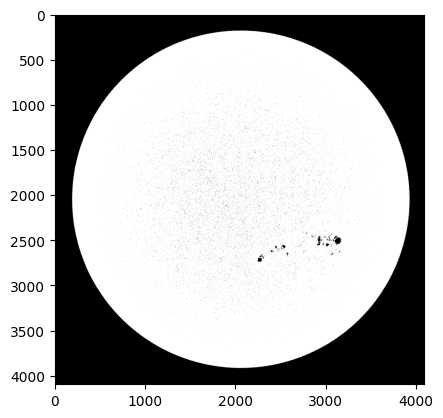

In [6]:
if sun_ellipse:
    mask = np.zeros_like(image) #black mask
    cv2.ellipse(mask, sun_ellipse, 255, -1)  #paint the elipse on mask (full inside, that's why -1)
    masked_binary = cv2.bitwise_and(image, mask)  

    new_binary=cv2.adaptiveThreshold(masked_binary,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,301,21)#THRESH_BINARY
    #_,new_binary=cv2.threshold(masked_binary,50,255,cv2.THRESH_BINARY)#THRESH_TOZERO
    new_binary =  cv2.bitwise_and(new_binary, mask)  
    plt.imshow(masked_binary, cmap='gray')
    plt.imshow(new_binary, cmap='gray')

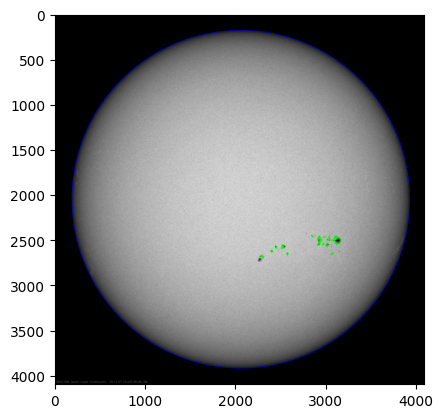

In [7]:
if sun_ellipse:  
    #caculate elipse area (in pixels^2)
    sun_area=np.pi*major_axis/2*minor_axis/2
 
    inner_contours, _ = cv2.findContours(new_binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)   #Find contours inside
    min_area=sun_area*MIN_SUNSPOT
    max_area = sun_area *MAX_SUNSPOT
    
    # Filtrowanie małych konturów
    filtered_contours = [cnt for cnt in inner_contours if (cv2.contourArea(cnt) > min_area and cv2.contourArea(cnt) < max_area)]
    filtered_contours.pop(0)
    
    image_contours = image_elipse.copy()
    cv2.drawContours(image_contours, filtered_contours, -1, (0, 255, 0), contour_size)  

    # Wyświetlenie obrazu
    plt.imshow(cv2.cvtColor(image_contours, cv2.COLOR_BGR2RGB))
    plt.show()

In [8]:
if filtered_contours:
    spots_area=0
    for contour in filtered_contours:
        spots_area+=cv2.contourArea(contour)
    print(f'Sun spots are on {spots_area/sun_area*100:.3f}% of sun area')
    if spots_area/sun_area*100<MIN_OVERALL_SUNSPOT_AREA:
        print("Example would be rejected")

Sun spots are on 0.118% of sun area


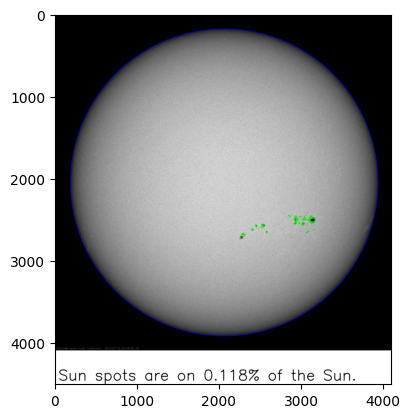

In [9]:
# Wysokość obrazu, żeby dodać tekst poniżej
height, width = image_contours.shape[:2]
# Stworzenie nowego obrazu z dodatkową przestrzenią na napis
image_with_text = cv2.copyMakeBorder(image_contours, 0, int(height/10), 0, 0, cv2.BORDER_CONSTANT, None, value = (255,255,255)) 

height, width = image_with_text.shape[:2]

# Dodanie napisu na dole
font = cv2.FONT_HERSHEY_SIMPLEX  # Czcionka
position = (int(width/100), int(height-height/100))
line_type = cv2.LINE_AA
cv2.putText(image_with_text, f'Sun spots are on {spots_area/sun_area*100:.3f}% of the Sun.', position , font, font_scale, 0, thickness, line_type)

# Zapisanie obrazu z napisem
cv2.imwrite('image_with_text.jpg', image_with_text)

# Wyświetlenie obrazu
plt.imshow(cv2.cvtColor(image_with_text, cv2.COLOR_BGR2RGB))